In [46]:
import sys
import os 
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

* Abaixo s√£o criadas as fun√ß√µes que v√£o nos ajudar nos processos de modelagem e ajuste dos dados.

In [48]:
from statsmodels.tsa.stattools import pacf

def get_lag_features(df, prefixo, target):
    return [col for col in df.columns if col.startswith(prefixo) and col != target]


def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
   
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    return significantLags


def getQlTransformation(x=None, bins=2):
    q = []; I = []; categories = list(range(bins))
    lower = x.min()
    quantile = 1 / bins
    cum = quantile
    ql_x = pd.Series(index=x.index, dtype="Int64")  # Garante dtype correto para evitar NaN
    i = 0

    while cum < 1:
        upper = x.quantile(cum)
        ql_x[(x >= lower) & (x < upper)] = categories[i]
        I.append((lower, upper))
        q.append(upper)
        lower = upper
        cum += quantile
        i += 1

    # √öltimo intervalo (para garantir que o maior valor seja inclu√≠do)
    ql_x[x >= lower] = categories[-1]
    I.append((lower, x.max()))
    
    return {'ql_x': ql_x, 'I': I, 'bins': bins, 'categories': categories, 'quantile': quantile}

from pgmpy.inference import VariableElimination

def getEvidence(df, X_qualitative, index):
    index_real = df.index[index]  # Obt√©m a chave real do √≠ndice temporal
    qualitativeRow = df.loc[index_real, X_qualitative]  

    return {'qualitative': qualitativeRow.to_dict()}

def predict(y_qualitative, df, modelInfer,X_qualitative, qlTrans):
    preds = pd.DataFrame(index=df.index)
    preds['~Valor_ql'] = pd.Series(index=df.index, dtype=object)

    for i in range(df.shape[0]):
        ev_i = getEvidence(df,X_qualitative, i)
        
        # Usa as chaves corretas ('qualitative' e 'quantitative')
        dist_i = modelInfer.query([y_qualitative], evidence=ev_i['qualitative'])

        # Encontra o √≠ndice da maior probabilidade corretamente
        index = np.argmax(dist_i.values)

        # Obt√©m a predi√ß√£o qualitativa
        qlPred_i = dist_i.state_names[y_qualitative][index]
        preds.loc[df.index[i], '~Valor_ql'] = qlPred_i

    return preds

# Contextualiza√ß√£o

Nos √∫ltimos anos, a oscila√ß√£o nos pre√ßos da gasolina tornou-se um dos problemas mais debatidos no Brasil, especialmente devido √† volatilidade acentuada a partir de 2020. Em mar√ßo daquele ano, o litro de gasolina custava, em m√©dia, R$ 4,598, e no intervalo de 12 meses apresentou uma alta de 27,26%. Entre 2020 e 2022, o pre√ßo da gasolina aumentou cerca de 2,6 vezes mais que a infla√ß√£o acumulada, medida pelo IPCA, que foi de 21,86% no per√≠odo, segundo o IBGE. Desde ent√£o, os pre√ßos t√™m variado semanalmente, alcan√ßando R$ 7,99 em alguns postos no ano de 2024, conforme dados da ANP.

Para esta an√°lise, foram considerados os anos de 2019 a 2024, um per√≠odo marcado por intensas flutua√ß√µes nos pre√ßos dos combust√≠veis. Essas oscila√ß√µes foram influenciadas por uma combina√ß√£o de fatores, incluindo as consequ√™ncias econ√¥micas da pandemia de COVID-19, que afetaram a produ√ß√£o e o consumo global; varia√ß√µes na cota√ß√£o do d√≥lar, dado que o Brasil depende de importa√ß√µes para parte de seu consumo de combust√≠veis; mudan√ßas nas pol√≠ticas de precifica√ß√£o da Petrobras, que ajusta os pre√ßos de acordo com o mercado internacional; al√©m de flutua√ß√µes no pre√ßo do petr√≥leo no mercado global e eventos geopol√≠ticos que impactaram o suprimento e a demanda por combust√≠veis.

Essa acentuada varia√ß√£o nos pre√ßos tornou a previs√£o de valores um desafio significativo. Esse tema tem despertado grande interesse tanto na academia quanto no setor privado, que buscam solu√ß√µes para compreender e prever as mudan√ßas no mercado de combust√≠veis. Apesar dos avan√ßos recentes nos m√©todos de previs√£o, muitos modelos ainda enfrentam dificuldades para capturar com precis√£o tanto a volatilidade dos pre√ßos semanais quanto as tend√™ncias de longo prazo, o que refor√ßa a necessidade de pesquisas cont√≠nuas e o desenvolvimento de ferramentas mais robustas para an√°lise desse mercado.


# Pr√©-processamento

## 2.1. Leitura  e an√°lise dos dados

Ao analisar as s√©ries temporais dos pre√ßos da gasolina, podemos observ√°-los em quatro momentos principais:

Per√≠odo anterior a 2020: Antes de 2020, os pre√ßos da gasolina apresentavam uma varia√ß√£o moderada. Embora houvesse uma leve subida seguida de uma queda, os pre√ßos raramente ultrapassavam a marca de 5 reais. Na maior parte das cidades, o pre√ßo se manteve dentro de um intervalo relativamente est√°vel, sem grandes flutua√ß√µes. A exce√ß√£o not√°vel foi Salvador, onde o pre√ßo da gasolina permaneceu praticamente constante durante esse per√≠odo, sem grandes varia√ß√µes, o que pode estar relacionado √† din√¢mica local do mercado de combust√≠veis e pol√≠ticas regionais.

In√≠cio da pandemia de COVID-19 (2020): Com o advento da pandemia de COVID-19 no in√≠cio de 2020, o cen√°rio econ√¥mico mundial sofreu uma forte mudan√ßa. Nos primeiros meses do ano, os pre√ßos da gasolina ca√≠ram, reflexo da queda na demanda global de combust√≠veis devido ao isolamento social e √† paralisa√ß√£o de diversas atividades econ√¥micas. No entanto, logo ap√≥s essa queda inicial, o pre√ßo come√ßou a aumentar de forma significativa. Esse aumento foi impulsionado pela crise econ√¥mica global provocada pela pandemia, que afetou o mercado de petr√≥leo e combust√≠veis, al√©m de desajustes nas cadeias de fornecimento. O impacto da pandemia causou uma eleva√ß√£o generalizada dos pre√ßos da gasolina em diversas partes do mundo, incluindo o Brasil, onde o mercado local foi afetado pela instabilidade econ√¥mica.

Ap√≥s 2022 ‚Äì Queda e recupera√ß√£o (2022): Em 2022, a situa√ß√£o econ√¥mica no Brasil e no mundo come√ßou a se estabilizar parcialmente. Os pre√ßos da gasolina passaram a se manter mais constantes por algumas semanas, mas logo em seguida iniciaram uma nova tend√™ncia de crescimento. Essa varia√ß√£o foi diretamente influenciada por fatores como a recupera√ß√£o econ√¥mica global p√≥s-pandemia, o aumento da demanda por combust√≠veis √† medida que a economia voltava ao normal e as flutua√ß√µes nos pre√ßos do petr√≥leo no mercado internacional. No entanto, o grande evento que afetou fortemente os pre√ßos foi a elei√ß√£o presidencial no Brasil no final de 2022. Durante esse per√≠odo, a pol√≠tica interna teve um papel importante na regula√ß√£o dos pre√ßos dos combust√≠veis. O governo que estava saindo adotou pol√≠ticas de redu√ß√£o de impostos sobre combust√≠veis para tentar aliviar o impacto da alta dos pre√ßos, o que resultou em uma queda significativa nos pre√ßos no final de 2022. Essa mudan√ßa foi vista como uma tentativa de controlar a infla√ß√£o e conquistar apoio popular em um momento de grande tens√£o pol√≠tica e social.

In√≠cio de 2023 ‚Äì Mudan√ßas pol√≠ticas e novo padr√£o de pre√ßos (2023): O in√≠cio de 2023 foi marcado pela posse de um novo presidente no Brasil, o que trouxe novas diretrizes econ√¥micas e pol√≠ticas para o pa√≠s. Nesse per√≠odo, os pre√ßos da gasolina voltaram a subir, impulsionados principalmente por ajustes nas pol√≠ticas de pre√ßos dos combust√≠veis e pela adapta√ß√£o do mercado a um novo cen√°rio econ√¥mico. O novo governo adotou uma s√©rie de medidas que afetaram diretamente o mercado de combust√≠veis, incluindo a revis√£o da pol√≠tica de subs√≠dios e o controle da infla√ß√£o. Apesar disso, os pre√ßos se estabilizaram em torno de 5 a 6 reais em muitas cidades, embora algumas localidades, como Fortaleza e Natal, registrassem valores mais altos devido a fatores regionais e √† oferta local de combust√≠veis. A pol√≠tica fiscal e a postura do novo governo em rela√ß√£o ao setor energ√©tico continuaram a influenciar a din√¢mica de pre√ßos durante esse per√≠odo, com tentativas de equilibrar o custo para o consumidor e a sustentabilidade das finan√ßas p√∫blicas.

Conclus√£o: O pre√ßo da gasolina no Brasil, assim como em outros pa√≠ses, √© influenciado por uma complexa intera√ß√£o de fatores econ√¥micos, pol√≠ticos e sociais. A an√°lise das s√©ries temporais revela que, ao longo dos √∫ltimos anos, essas vari√°veis exerceram um impacto significativo nas flutua√ß√µes de pre√ßos.

Primeiramente, fatores econ√¥micos globais, como a pandemia de COVID-19, desempenharam um papel crucial, provocando quedas iniciais seguidas de aumentos expressivos nos pre√ßos da gasolina. A crise sanit√°ria gerou uma desestabiliza√ß√£o das cadeias de fornecimento, elevando os custos dos combust√≠veis, enquanto a recupera√ß√£o econ√¥mica trouxe uma nova press√£o sobre os pre√ßos. No Brasil, a pol√≠tica interna tamb√©m teve grande peso, especialmente em momentos de incerteza pol√≠tica, como nas elei√ß√µes de 2022, quando mudan√ßas nas pol√≠ticas fiscais, como a redu√ß√£o de impostos sobre combust√≠veis, resultaram em uma queda tempor√°ria no pre√ßo.

Al√©m disso, o impacto de decis√µes pol√≠ticas no setor energ√©tico, especialmente com a troca de governos, revelou-se fundamental para moldar o comportamento dos pre√ßos nos anos seguintes. O novo governo de 2023, ao adotar medidas voltadas ao controle da infla√ß√£o e √† gest√£o da pol√≠tica de pre√ßos dos combust√≠veis, teve uma influ√™ncia direta no aumento gradual dos pre√ßos, com algumas regi√µes, como Fortaleza e Natal, mostrando varia√ß√µes ainda mais pronunciadas.

Portanto, o pre√ßo da gasolina √© resultado de uma conflu√™ncia de fatores globais, nacionais e regionais, com o mercado de combust√≠veis sendo sens√≠vel a mudan√ßas econ√¥micas externas, como o valor do petr√≥leo, e a decis√µes pol√≠ticas internas, que buscam equilibrar interesses econ√¥micos e sociais. A compreens√£o desses m√∫ltiplos impactos √© essencial para analisar o comportamento dos pre√ßos e suas varia√ß√µes ao longo do tempo, evidenciando a complexidade desse mercado e a necessidade de pol√≠ticas p√∫blicas que considerem tanto os desafios econ√¥micos globais quanto as realidades locais.

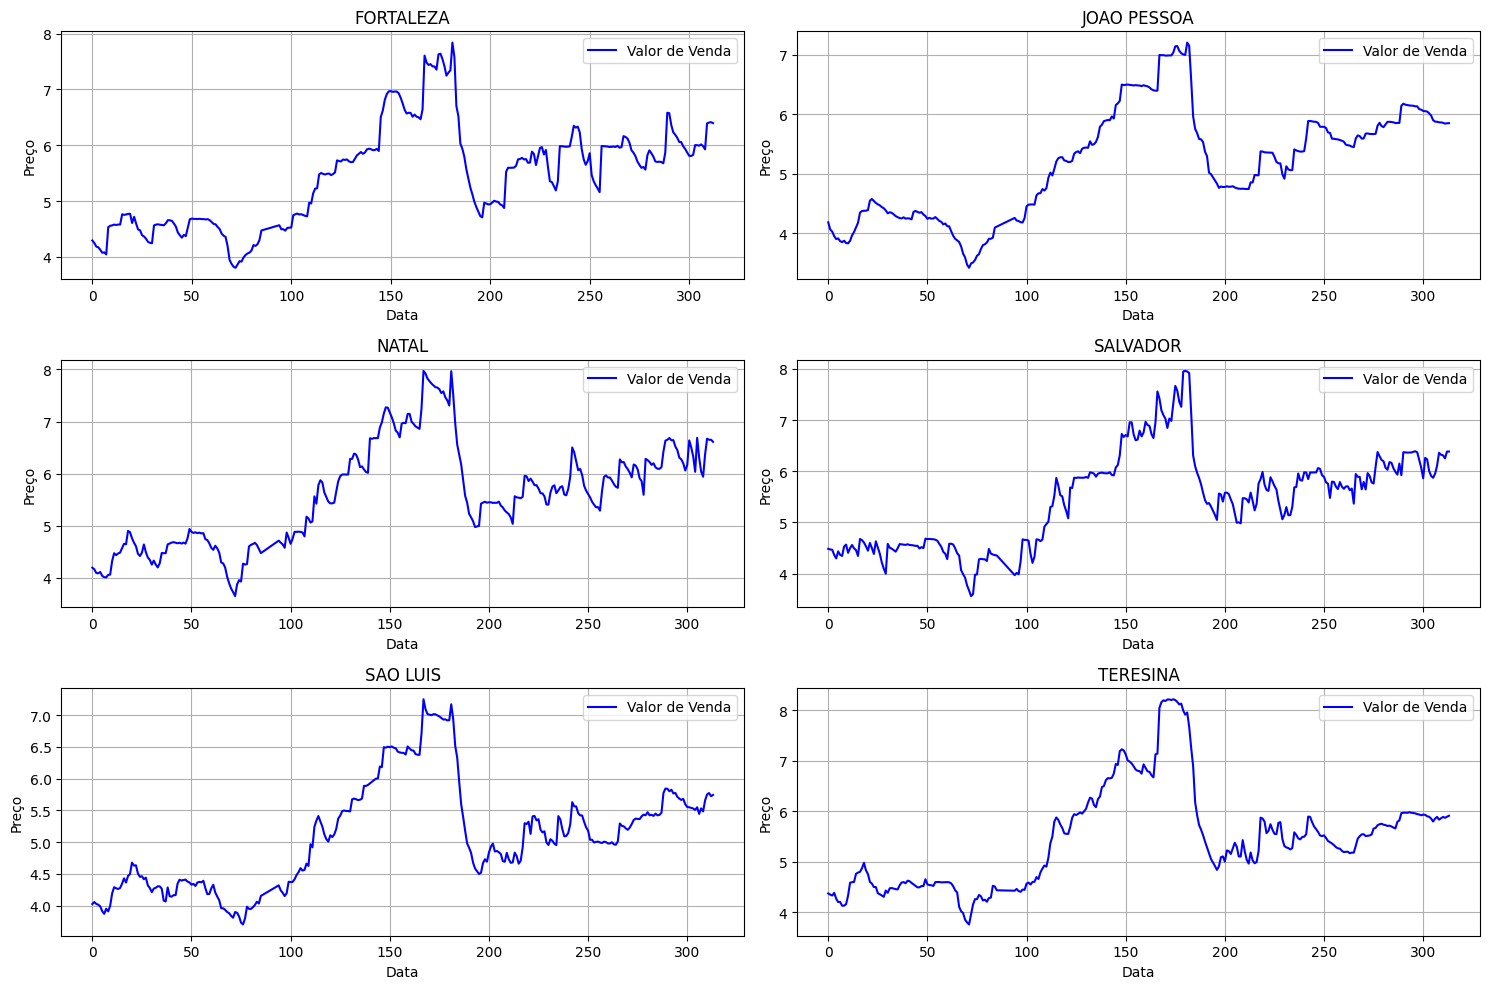

In [49]:
# Diret√≥rio de entrada
input_dir = "../data/Gold"

# Listar arquivos CSV na pasta Gold
files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

# Dicion√°rio para armazenar os DataFrames
data_frames = {}

# Configura√ß√£o da grade de plots
rows, cols = 3, 2  # Layout 3x2
num_plots = len(files)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()  # Facilita o acesso aos subplots

for i, file in enumerate(files):
    file_path = os.path.join(input_dir, file)
    
    # Carregar dados
    data = pd.read_csv(file_path, delimiter=',') 
    
    # Salvar o DataFrame no dicion√°rio com nome da s√©rie
    serie_name = file.replace(".csv", "")
    data_frames[serie_name] = data  # Armazenando o DataFrame no dicion√°rio
    
    # Plot no subplot correspondente
    axes[i].plot(data['Valor_de_Venda'], color='blue', label='Valor de Venda')
    axes[i].set_title(file.replace(".csv", ""))
    axes[i].set_xlabel('Data')
    axes[i].set_ylabel('Pre√ßo')
    axes[i].grid(True)
    axes[i].legend()

# Remover eixos vazios se n√£o preencher toda a grade
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##  2.3. Transforma√ß√£o de vari√°veis

Para a etapa de aplica√ß√£o dos modelos √© necess√°rio cria√ß√£o/transforma√ß√£o das variaveis preditoras, ou seja, a cria√ß√£o dos valores de lags como preditoras abaixo utilizamos a fun√ß√£o ``getSignificantLags`` que utiliza PACF para avaliar os valores de lags mais relevantes.  
Com isso, construimos como variaveis preditoras os valores de venda do pre√ßo da gasolina de forma defasada para cada uma das series.

In [50]:
# N√∫mero de bins para a discretiza√ß√£o
bins = 8 

# Dicion√°rio para armazenar qlTrans de cada cidade
qlTrans_dict = {}

# Loop para cada DataFrame em data_frames
for nome, df in data_frames.items():
    # Aplicar QL discretiza√ß√£o
    qlTrans = getQlTransformation(x=df['Valor_de_Venda'], bins=bins)
    
    # Salvar qlTrans no dicion√°rio para cada cidade
    qlTrans_dict[nome] = qlTrans
    
    # Adicionar a coluna 'Valor_ql' ao DataFrame com a transforma√ß√£o qualitativa
    df['Valor_ql'] = qlTrans['ql_x']
    
    # Calcular lags significativos
    significant_lags_discrete = getSignificantLags(df['Valor_ql'], nLags=7, alpha=0.05)

    print(f"Para {nome}:")
    print('Lag discrete value:', significant_lags_discrete)

    # Criar lags relevantes
    for lag in significant_lags_discrete:
        df[f'Valor_ql_lag{lag}'] = df['Valor_ql'].shift(lag)
        
    # Remover linhas com NaNs geradas pelos lags
    df.dropna(inplace=True)
    
    # Dropar os √∫ltimos max(lags) valores para manter consist√™ncia
    if significant_lags_discrete:
        df = df.iloc[:-max(significant_lags_discrete)]
    
    # Atualizar no dicion√°rio
    data_frames[nome] = df



Para FORTALEZA:
Lag discrete value: [1]
Para JOAO PESSOA:
Lag discrete value: [1, 4]
Para NATAL:
Lag discrete value: [1]
Para SALVADOR:
Lag discrete value: [1, 2, 3]
Para SAO LUIS:
Lag discrete value: [1, 5]
Para TERESINA:
Lag discrete value: [1]


Tamb√©m √© necess√°rio fazer alguns ajustes nos dados.  
Abaixo ajustamos a coluna de data convertendo em valores ``datetime`` e tambem definimos ela como index dos dataframes, al√©m disso tamb√©m √© feito o drop da coluna `Produto` pois trabalharemo somente com o pre√ßo da gasolina e tamb√©m dropamos a coluna `Valor_de_venda` pois nesse notebook usaremos somente valores qualitativos.

In [51]:
# Para cada DataFrame no dicion√°rio 'data_frames'
for nome, df in data_frames.items():
    # Converter a coluna 'Data da Coleta' para datetime
    df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'])
    
    # Definir 'Data da Coleta' como o √≠ndice do DataFrame
    df.set_index('Data da Coleta', inplace=True)
    df.drop(columns=['Produto','Valor_de_Venda'], inplace=True)  # Remover a coluna 'Valor_ql' se necess√°rio
    # Atualizar no dicion√°rio
    data_frames[nome] = df

##  2.4. Parti√ß√£o dos dados de treinamento entre treino e valida√ß√£o

A seguir fazemos as etapas de particionar os dados em treinamento,teste e valida√ß√£o. Esta etapa √© crucial para avaliar os desempenhos dos modelos propostos.  
* Para isso dividimos o conjunto de dados da seguinte maneira:
    * O treinamento √© composto por todos os dados, exceto as 10 ultimas observa√ß√µes da s√©rie.
    * O teste √© composto pelas primeiras 5 observa√ß√µes ap√≥s o treinamento.
    * A valida√ß√£o √© composta pelas primeiras 5 observa√ß√µes ap√≥s o teste.  

Com isso, temos as parti√ß√µes da forma exata para treinar e avaliar como esta o modelo ate mais de um m√™s no futuro que s√£o os 5 valores para treinamento e teste.  

In [52]:
train_data_dict = {}
val_data_dict = {}
test_data_dict = {}

for nome, df in data_frames.items():
    train_data = df.iloc[:-10]     # Todas menos as 20 √∫ltimas
    val_data = df.iloc[-10:-5]    # Da posi√ß√£o -20 at√© -10 (valida√ß√£o)
    test_data = df.iloc[-5:]      # As √∫ltimas 10 linhas (teste)

    train_data_dict[nome] = train_data
    val_data_dict[nome] = val_data
    test_data_dict[nome] = test_data


# Modelagem

Nas se√ß√µes abaixo trabalhamos com a modelagem dos dados, aplicando tanto modelos manualmente definidos quanto modelos otimamente definidos.  
Os modelos aplicados se dividem em duas se√ß√µes modelos bayesianos usando a estatistica bayesiana, e os modelos da scikit-lear como Support Vector Machine, XGBoost Classifier, Random Forest Classifier, Logistic Regression.

## 3.1. Modelos manualmente definidos

Abaixo trazemos os modelos manualmente definidos, estes modelos tem os par√¢metros definidos de forma manual, estes modelos tendem a ter menor desempenho pois modelos com par√¢metros definidos manualmente tendem a ser menos robustos e ter um pior desempenho.

### 3.1.1. Modelo bayesiano

Nesta se√ß√£o abordamos o modelo bayesiano usando a biblioteca `pgmpy`.  
O `pgmpy` √© uma biblioteca Python para modelagem de Redes Bayesianas, que s√£o modelos gr√°ficos probabil√≠sticos representando depend√™ncias condicionais entre vari√°veis aleat√≥rias, este modelo √© um modelo supervisionado que usa probabilidades condicionais para prever uma vari√°vel alvo (classe).


A ideia central √© aplicar o Teorema de Bayes para inferir a probabilidade da classe com base nas evid√™ncias (vari√°veis preditoras).

No c√≥digo abaixo ajustamos as vari√°veis do conjunto de treinamento para estrutramos na forma de um grafo, ou seja, com v√©rtices e arestas que ligam as vari√°veis, estas etapas s√£o necess√°rias para usar o modelo bayesiano da biblioteca `pgmpy`.

In [53]:
graph_dict = {}
X_qualitative_dict = {}

y_qualitative = 'Valor_ql'


for nome, train_data in train_data_dict.items():
    graph = []

    X_qualitative = get_lag_features(train_data, 'Valor_ql_', y_qualitative)

        # Armazena essas vari√°veis nos dicion√°rios
    X_qualitative_dict[nome] = X_qualitative

    for coluna_lag in X_qualitative:
        graph.append((coluna_lag, y_qualitative))

    graph_dict[nome] = graph


Abaixo √© feita a cria√ß√£o do modelo bayesiano usando o grafo criado anteriormente, o modelo √© criado e treinado para cada uma das series.  
O metodo de inferencia √© o metodo `VariableElimination`.


O m√©todo de infer√™ncia `VariableElimination` (Elimina√ß√£o de Vari√°veis) √© um algoritmo exato e cl√°ssico usado em infer√™ncia probabil√≠stica em redes bayesianas (ou redes de cren√ßa). Ele √© usado para calcular probabilidades marginais ou condicionais de vari√°veis de interesse, dado um conjunto de evid√™ncias.


* üéØ Objetivo

O objetivo √© calcular, por exemplo:

$
P(X \mid E = e)
$
onde:

- $ X $ √© a vari√°vel (ou conjunto de vari√°veis) de interesse.
- $ E = e $ √© um conjunto de evid√™ncias observadas.

Para fazer isso, o algoritmo elimina (ou **marginaliza**) as vari√°veis **n√£o observadas** e **n√£o de interesse** do modelo, uma por uma, usando **soma marginal** (ou produto, se for fator de probabilidade condicional).

---

* üß† Etapas do algoritmo

    * **Fatores iniciais**  
    Come√ßa com os fatores da rede ‚Äî geralmente tabelas de probabilidade condicional (CPTs).

    * **Incorpora√ß√£o da evid√™ncia**  
    As vari√°veis evidenciadas (como \( E = e \)) s√£o inseridas nos fatores, reduzindo-os.

    * **Elimina√ß√£o das vari√°veis ocultas**  
    Para cada vari√°vel que n√£o est√° no conjunto de evid√™ncia nem √© a vari√°vel alvo, o algoritmo:
    
    - Multiplica todos os fatores que a cont√™m.
    - Marginaliza (soma) sobre essa vari√°vel, criando um novo fator.
    - Substitui os antigos fatores pelo novo.

    * **Resultado final**  
    Ao final, os fatores restantes s√£o multiplicados, e o resultado √© **normalizado** (se necess√°rio) para obter uma **distribui√ß√£o de probabilidade**.

---


In [54]:
from pgmpy.models import DiscreteBayesianNetwork 
from pgmpy.estimators import BayesianEstimator

# Criando os modelos e armazenando em dicion√°rios
bayesian_models = {}
bayesian_inferences = {}

y_qualitative = 'Valor_ql'

for nome, train_data in train_data_dict.items():

    # Criar o grafo da rede bayesiana (somente com vari√°veis qualitativas)
    graph = []

    # Adicionar vari√°veis qualitativas ao gr√°fico
    X_qualitative_data = X_qualitative_dict[nome]  # Obt√©m as vari√°veis qualitativas para esse munic√≠pio
    for coluna_lag in X_qualitative_data:
        # Conectando cada vari√°vel de lag qualitativa ao target
        graph.append((coluna_lag, y_qualitative))

    # Criar o modelo de Rede Bayesian apenas com vari√°veis qualitativas
    beModel = DiscreteBayesianNetwork(graph)
    
    # Estimar o modelo com o BayesianEstimator
    beModel.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=3 * bins)
    
    # Realizar infer√™ncia com a vari√°vel de elimina√ß√£o
    beInfer = VariableElimination(beModel)
    
    # Verificar o modelo
    model_check = beModel.check_model()
    
    # Armazenar os resultados
    bayesian_models[nome] = beModel
    bayesian_inferences[nome] = beInfer




INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N', 'Valor_ql_lag4': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N', 'Valor_ql_lag2': 'N', 'Valor_ql_lag3': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N', 'Valor_ql_lag5': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N'}


Abaixmo mostramos os grafos do modelo bayesiano, com isso podemos ver quais vari√°veis e lags influenciam na vari√°vel target.

Renderizando grafo para: FORTALEZA


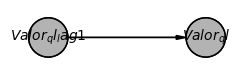

Renderizando grafo para: JOAO PESSOA


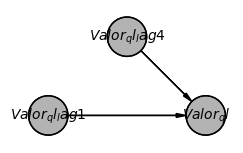

Renderizando grafo para: NATAL


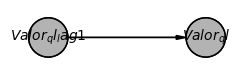

Renderizando grafo para: SALVADOR


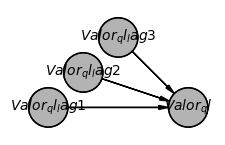

Renderizando grafo para: SAO LUIS


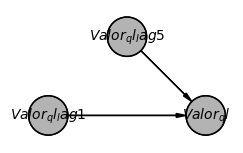

Renderizando grafo para: TERESINA


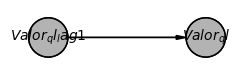

In [55]:
import matplotlib.pyplot as plt

# Iterar sobre todos os modelos no dicion√°rio
for nome, modelo in bayesian_models.items():
    print(f"Renderizando grafo para: {nome}")

    try:
        # Criar o gr√°fico Daft
        daft_graph = modelo.to_daft(node_pos='planar', latex=True)

        # Renderizar o gr√°fico
        daft_graph.render()
        plt.show()
        
    except Exception as e:
        print(f"Erro ao renderizar o grafo para {nome}: {e}")


Abaixo √© feita as predi√ß√µes utilizando o modelo criado anteriormente e as vari√°veis qualitativas de lags que foram definidas anteriormente.

A fun√ß√£o `predict`√© chamada para realizar previs√µes nos conjuntos de dados de teste, com o modelo `beInfer` (infer√™ncia Bayesiana) e a tabela de transforma√ß√£o `qlTrans` que mapeia as vari√°veis qualitativas.  
O resultado da fun√ß√£o `predict` √© armazenado em um dici√≥nario que armazena as predi√ß√µes para cada uma das cidades.  

In [56]:
predict_test_dict = {}

for nome, df in test_data_dict.items():
    '''predics_test = predict(y_qualitative='Valor_ql',
                        df=df,
                        modelInfer=bayesian_inferences[nome],
                        X_qualitative=X_qualitative_dict[nome],
                        qlTrans=qlTrans_dict[nome])
    '''
    model = bayesian_models[nome]
    df = test_data_dict[nome]
    predict_test_dict[nome] =  predict(y_qualitative='Valor_ql',
                        df=df,
                        modelInfer=bayesian_inferences[nome],
                        X_qualitative=X_qualitative_dict[nome],
                        qlTrans=qlTrans_dict[nome])




Abaixo √© criado o dicion√°rio que armazena as m√©tricas de erro para cada s√©rie utilizada no modelo de infer√™ncia bayesiana.

In [57]:
from sklearn.metrics import log_loss, mean_absolute_error

results_bayes_inference = []

for nome, predics_test in predict_test_dict.items():
    y_true = test_data_dict[nome]['Valor_ql']
    y_pred = predics_test['~Valor_ql']  # classes previstas

    # Acur√°cia (baseada em erro absoluto m√©dio)
    acuracia = 1 - abs(y_true - y_pred).mean()

    # MAE
    mae = mean_absolute_error(y_true, y_pred)

    results_bayes_inference.append({
        'Cidade': nome,
        'Modelo': 'Bayes Inference',
        'Acur√°cia': acuracia,
        'MAE': mae
    })

# DataFrame com os resultados
results_bayes_inference_df = pd.DataFrame(results_bayes_inference)


### Modelos sklearn

Abaixo s√£o criados os modelos manualmente definidos da scikit-lear como Support Vector Machine, XGBoost Classifier, Random Forest Classifier, Logistic Regression.  
Todos os modelos abaixo tem os par√¢metros definidos de forma manual, buscando trazer o melhor desempenho e robustez para o modelo.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models_with_params_manual = {

    'Logistic Regression': LogisticRegression(
        C=1.0,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000
    ),

    'Random Forest Classifier': RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        criterion='gini',
        random_state=42
    ),

    'XGBoost Classifier': XGBClassifier(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.05,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),

    'Support Vector Machine': SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale'
    )

}

No codigo abaixo √© feita as predi√ß√µes dos dados de teste para cada cidade utilizando os modelos definidos anteriormente.   
Nesta etapa fazemos as predi√ß√µes dos dados e o calculo das metricas de erro para cada cidade, salvando tudo em um dataframe para ser an√°lisado em outra se√ß√£o.

In [59]:
from sklearn.metrics import accuracy_score

# Armazenar resultados para todas as s√©ries
all_results = []

# Armazenar melhor modelo por s√©rie
best_models_dict = {}

# Loop por cada s√©rie temporal (ou munic√≠pio)
for nome in train_data_dict.keys():
    train_data = train_data_dict[nome]
    test_data = test_data_dict[nome]

    y_train = train_data['Valor_ql']
    y_test = test_data['Valor_ql']
    X_train = train_data.drop(columns=['Valor_ql'])
    X_test = test_data.drop(columns=['Valor_ql'])

    best_accuracy = float('-inf')
    superior_model = None
    superior_model_name = None

    # Loop por cada modelo com par√¢metros fixos
    for name, model in models_with_params_manual.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        mae = mean_absolute_error(y_true, y_pred)

        all_results.append({
            'Cidade': nome,
            'Modelo': name,
            'Acur√°cia': accuracy,
            'MAE': mae
        })

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_MAE = mae
            superior_model = model
            superior_model_name = name

    # Salva o melhor modelo dessa s√©rie
    best_models_dict[nome] = {
        'modelo': superior_model,
        'nome_modelo': superior_model_name,
        'acuracia': best_accuracy,
        'MAE': best_MAE
    }

# DataFrame com os resultados de todos os modelos testados
all_results_df = pd.DataFrame(all_results)

# DataFrame com o melhor modelo de cada munic√≠pio
melhores_resultados = []

for cidade, info in best_models_dict.items():
    melhores_resultados.append({
        'Cidade': cidade,
        'Modelo': info['nome_modelo'],
        'Acur√°cia': info['acuracia'],
        'MAE': info['MAE']
    })

melhores_modelos_df = pd.DataFrame(melhores_resultados)


No c√≥digo abaixo √© feita concatena√ß√£o dos dataframes de resultados do modelo bayesiano e do resultado dos modelos da `scikit-learn` dessa forma a an√°lise feita na se√ß√£o de **Medidas de desempenho** ser√° possivel discutir a cerca de todos os modelos que foram definidas manualmente.

In [60]:
df_combined_ManParam = pd.concat([results_bayes_inference_df, all_results_df], ignore_index=True)

df_combined_ManParam = df_combined_ManParam.dropna(subset=['Cidade', 'Modelo', 'Acur√°cia','MAE'])

## 3.2. Modelos otimamente definidos

Modelos otimizados utilizam estrat√©gias sistem√°ticas de busca ‚Äî como valida√ß√£o cruzada, otimiza√ß√£o bayesiana ou algoritmos evolutivos ‚Äî para selecionar automaticamente a melhor combina√ß√£o de hiperpar√¢metros. Esse processo visa maximizar m√©tricas de desempenho espec√≠ficas, reduzindo a subjetividade e o vi√©s inerentes √† defini√ß√£o manual. Em compara√ß√£o com modelos ajustados empiricamente, os modelos otimizados tendem a apresentar maior generaliza√ß√£o e desempenho superior nos dados de teste, uma vez que exploram de forma mais abrangente o espa√ßo de configura√ß√£o do modelo.

### 3.2.1. Modelo bayesiano com simula√ß√£o

Para otimizar o modelo bayesiano usamos um modelo com simula√ß√£o usando a biblioteca `PyMC` traga uma explica√ß√£o sobre simula√ß√£o e  sobre a biblioteca `PyMC`.
Em estat√≠stica bayesiana, simula√ß√£o se refere ao uso de m√©todos computacionais para aproximar distribui√ß√µes posteriores de par√¢metros, quando n√£o √© poss√≠vel obt√™-las de forma anal√≠tica. Isso √© especialmente necess√°rio em modelos complexos ou hier√°rquicos, nos quais a posterior n√£o possui forma fechada.


A infer√™ncia por simula√ß√£o usando o `PyMC` pode ser mais vantajosa do que os m√©todos tradicionais de infer√™ncia exata, como o VariableElimination da biblioteca `pgmpy`, especialmente em contextos mais complexos. Enquanto o `pgmpy` √© eficaz para redes discretas e de pequena escala, onde as distribui√ß√µes de probabilidade podem ser manipuladas diretamente por meio de tabelas e opera√ß√µes anal√≠ticas, ele apresenta limita√ß√µes quando lidamos com modelos maiores, cont√≠nuos ou hier√°rquicos. O `PyMC`, por outro lado, permite que os par√¢metros do modelo sejam tratados como vari√°veis aleat√≥rias com distribui√ß√µes a priori, possibilitando a constru√ß√£o de modelos bayesianos completos e flex√≠veis. Utilizando t√©cnicas como *MCMC* (Markov Chain Monte Carlo), o `PyMC` simula amostras da distribui√ß√£o posterior, o que permite estimar n√£o apenas valores pontuais, mas tamb√©m intervalos de credibilidade que capturam a incerteza da infer√™ncia. Al√©m disso, sua capacidade de modelar rela√ß√µes n√£o-lineares e estruturas hier√°rquicas torna-o uma ferramenta muito mais poderosa para an√°lise bayesiana em situa√ß√µes onde os m√©todos exatos, como os do `pgmpy`, tornam-se invi√°veis computacionalmente ou incapazes de capturar a complexidade do fen√¥meno modeladado.

Abaixo importamos a classe onde foi criado os codigo de ``fit()`` e ``predict_proba()`` com a biblioteca `PyMC`. 

O m√©todo `fit` √© respons√°vel por ajustar um modelo bayesiano de regress√£o log√≠stica multinomial para vari√°veis categ√≥ricas usando a biblioteca PyMC. Nele, os dados s√£o divididos em vari√°veis preditoras `X` e uma vari√°vel resposta `y`, que representa classes discretas. O modelo assume que a probabilidade de cada classe √© determinada por uma combina√ß√£o linear dos preditores com coeficientes espec√≠ficos para cada classe. Esses coeficientes s√£o representados por distribui√ß√µes a priori normais (`beta0` para os interceptos e `betas` para os pesos das vari√°veis), e os logits ‚Äî combina√ß√£o linear entre `X` e `betas` acrescida de `beta0` ‚Äî s√£o usados para parametrizar uma distribui√ß√£o categ√≥rica para a vari√°vel observada. A infer√™ncia √© feita com o m√©todo `find_MAP`, que encontra o ponto de m√°ximo da distribui√ß√£o a posteriori, fornecendo estimativas pontuais para os par√¢metros do modelo.

J√° o m√©todo `predict_proba` utiliza os par√¢metros estimados durante o `fit` para fazer predi√ß√µes em novos dados. Primeiro, ele calcula os logits ‚Äî valores antes da fun√ß√£o softmax ‚Äî como o produto da matriz de preditores `X_new` pelos pesos `betas`, somando o intercepto `beta0`. Em seguida, aplica a fun√ß√£o softmax aos logits para converter esses valores em probabilidades associadas a cada classe. O resultado √© uma matriz onde cada linha representa uma observa√ß√£o e cada coluna representa a probabilidade da observa√ß√£o pertencer a uma classe espec√≠fica. A predi√ß√£o final para cada inst√¢ncia √© dada pela classe com maior probabilidade, obtida com `np.argmax`, fornecendo uma estimativa categ√≥rica a partir de um modelo que foi ajustado para aprender as rela√ß√µes probabil√≠sticas entre vari√°veis quantitativas e uma resposta qualitativa.


In [61]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

from BayesModel import BayesMapClassifier

Abaixo √© usado o m√©todo ``fit()`` e ``predict_proba()`` para cada um das s√©ries.

In [62]:
predictions_dict = {}

for nome, df_test in test_data_dict.items():
    print(f"Processando: {nome}")
    MapInference = BayesMapClassifier()
    # Inicializa e treina o modelo
    
    df_train = train_data_dict[nome]
    MapInference.fit(df_train)

    # Previs√£o em lote
    X_test = df_test.drop(columns=["Valor_ql"])
    y_pred = MapInference.predict_proba(X_test)

    predictions_dict[nome] = y_pred


Processando: FORTALEZA
Processando: JOAO PESSOA
Processando: NATAL
Processando: SALVADOR
Processando: SAO LUIS
Processando: TERESINA


In [63]:
import pandas as pd
from sklearn.metrics import accuracy_score

resultados = []

for nome, y_pred in predictions_dict.items():
    y_true = test_data_dict[nome]['Valor_ql']
    
    acuracia = accuracy_score(y_true, y_pred)
    # MCC
    mae = mean_absolute_error(y_true, y_pred)


    resultados.append({
        "Cidade": nome,
        "Modelo": "BayesInferenceMap",
        "Acur√°cia": acuracia,
        'MAE': mae
    })

df_resultados = pd.DataFrame(resultados)


### 3.2.2 Modelos sklearn

Abaixo s√£o apresentados os modelos otimizados por meio do *BayesSearchCV*, uma t√©cnica de busca bayesiana que ajusta automaticamente os hiperpar√¢metros com base em desempenho validado. Essa abordagem busca de forma eficiente as melhores combina√ß√µes de par√¢metros para cada modelo, equilibrando explora√ß√£o e explora√ß√£o do espa√ßo de busca, com o objetivo de maximizar a performance preditiva e a robustez dos classificadores. A utiliza√ß√£o do *BayesSearchCV* permite encontrar configura√ß√µes que muitas vezes superam aquelas definidas manualmente, ao considerar intera√ß√µes complexas entre os hiperpar√¢metros e adaptando-se melhor aos dados do problema. 

Aplicaremos os modelos que j√° vem sendo usado da scikit-lear como Support Vector Machine, XGBoost Classifier, Random Forest Classifier, Logistic Regression.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from skopt.space import Real, Integer, Categorical

models_with_params = {

    # Modelos de classifica√ß√£o
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'param_grid': {
            'C': Real(0.01, 10, prior='log-uniform'),
            'penalty': Categorical(['l2']),
            'solver': Categorical(['lbfgs'])
        }
    },
    'Random Forest Classifier': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': Integer(100, 200),
            'max_depth': Categorical([None, 10, 30]),
            'criterion': Categorical(['gini', 'entropy', 'log_loss'])
        }
    },
    'XGBoost Classifier': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'param_grid': {
            'n_estimators': Integer(100, 200),
            'max_depth': Integer(3, 10),
            'learning_rate': Real(0.01, 0.1, prior='log-uniform')
        }
    },
    'Support Vector Machine': {
        'model': SVC(),
        'param_grid': {
            'C': Real(0.1, 10.0, prior='log-uniform'),
            'kernel': Categorical(['linear', 'rbf']),
            'gamma': Categorical(['scale', 'auto'])
        }
    },

}


No codigo abaixo √© feita as predi√ß√µes dos dados de teste para cada cidade utilizando os modelos otimamente definidos anteriormente.   
Nesta etapa fazemos as predi√ß√µes dos dados e o calculo das metricas de erro para cada um das cidade.  
Ap√≥s isso, as m√©tricas s√£o salvas em um dataframe para ser an√°lisado em outra se√ß√£o.

In [65]:
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV


# Armazenar resultados para todas as s√©ries
all_results = []

# Armazenar melhor modelo por s√©rie
best_models_dict = {}

# Loop sobre todas as s√©ries (ex: 'FORTALEZA', 'CAUCAIA' etc.)
for nome in train_data_dict.keys():
    train_data = train_data_dict[nome]
    test_data = test_data_dict[nome]

    y_train = train_data['Valor_ql']
    y_test = test_data['Valor_ql']
    X_train = train_data.drop(columns=['Valor_ql'])
    X_test = test_data.drop(columns=['Valor_ql'])

    best_accuracy = float('-inf')
    superior_model = None
    superior_model_name = None

    # Loop para aplicar BayesSearchCV e avaliar modelos
    for name, config in models_with_params.items():
        model = config['model']
        param_space = config['param_grid']

        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=param_space,
            scoring='accuracy',
            cv=5,
            n_iter=30,
            n_jobs=-1,
            refit=True,
            random_state=42
        )

        bayes_search.fit(X_train, y_train)
        best_model = bayes_search.best_estimator_

        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        
        all_results.append({
            'Cidade': nome,
            'Modelo': name,
            'Acur√°cia': accuracy,
            'MAE': mae
            
        })

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_MAE = mae
            superior_model = best_model
            superior_model_name = name
 
    # Salva o melhor modelo dessa s√©rie
    best_models_dict[nome] = {
        'modelo': superior_model,
        'nome_modelo': superior_model_name,
        'acuracia': best_accuracy,
        'MAE': best_MAE
    }

# DataFrame com os resultados
all_results_df = pd.DataFrame(all_results)

# DataFrame com os resultados de todos os m odelos testados
all_results_df = pd.DataFrame(all_results)

# DataFrame com o melhor modelo de cada munic√≠pio
melhores_resultados = []

for cidade, info in best_models_dict.items():
    melhores_resultados.append({
        'Cidade': cidade,
        'Modelo': info['nome_modelo'],
        'Acur√°cia': info['acuracia'],
        'MAE': info['MAE']
    })

melhores_modelos_df = pd.DataFrame(melhores_resultados)


No c√≥digo abaixo √© feita concatena√ß√£o dos dataframes de resultados do modelo bayesiano da biblioteca `PyMC` e do resultado dos modelos otimamente definidos da `scikit-learn` dessa forma a an√°lise feita na se√ß√£o de **Medidas de desempenho** ser√° possivel discutir a cerca de todos os modelos que foram definidas manualmente.

In [66]:
df_combined_HipParam = pd.concat([df_resultados, all_results_df], ignore_index=True)

df_combined_HipParam = df_combined_HipParam.dropna(subset=['Cidade', 'Modelo', 'Acur√°cia','MAE'])

## 3.3. Medidas de desempenho

*  Acur√°cia
    - **Defini√ß√£o**: Mede a propor√ß√£o de previs√µes corretas em rela√ß√£o ao total de previs√µes realizadas.
    - **Uso**: √â uma m√©trica simples e intuitiva, √∫til especialmente quando as classes est√£o **balanceadas**.
    - **Limita√ß√£o**: Pode ser **enganosa** em cen√°rios com classes **desbalanceadas**, pois erros em classes minorit√°rias t√™m pouco impacto no valor final da acur√°cia.

* MAE (Mean Absolute Error)
    - **Defini√ß√£o**: Calcula a **m√©dia da diferen√ßa absoluta** entre os valores reais e os valores previstos.
    - **Uso**: √â especialmente apropriada para **classifica√ß√£o ordinal**, onde existe uma **ordem natural entre as classes** (por exemplo, de 0 a 6).
    - **Vantagem**: Penaliza erros **proporcionalmente √† dist√¢ncia** entre as classes ‚Äî errar de 0 para 1 √© menos grave do que errar de 0 para 6.


### 3.3.1. Modelos Manualmente definidos

A seguir veremos as medidas de desempenho para os modelos manualmente definidos. 

#### 3.3.1.1. Acur√°cia

A seguir, observamos a medida de acur√°cia por cidade. Nota-se que, em algumas localidades, os modelos apresentam melhor desempenho, como √© o caso de Jo√£o Pessoa e Teresina, onde a acur√°cia atingiu o valor m√°ximo de 1.0, indicando uma adapta√ß√£o perfeita dos modelos a essas cidades.

Em seguida, destaca-se a cidade de Natal, que obteve a maior acur√°cia depois de Jo√£o Pessoa e Teresina.

Por outro lado, cidades como S√£o Lu√≠s, Fortaleza e Salvador apresentaram desempenhos inferiores, com acur√°cia igual ou inferior a 0.6, indicando que os modelos definidos manualmente n√£o conseguiram se adaptar com a mesma efic√°cia nessas localidades.

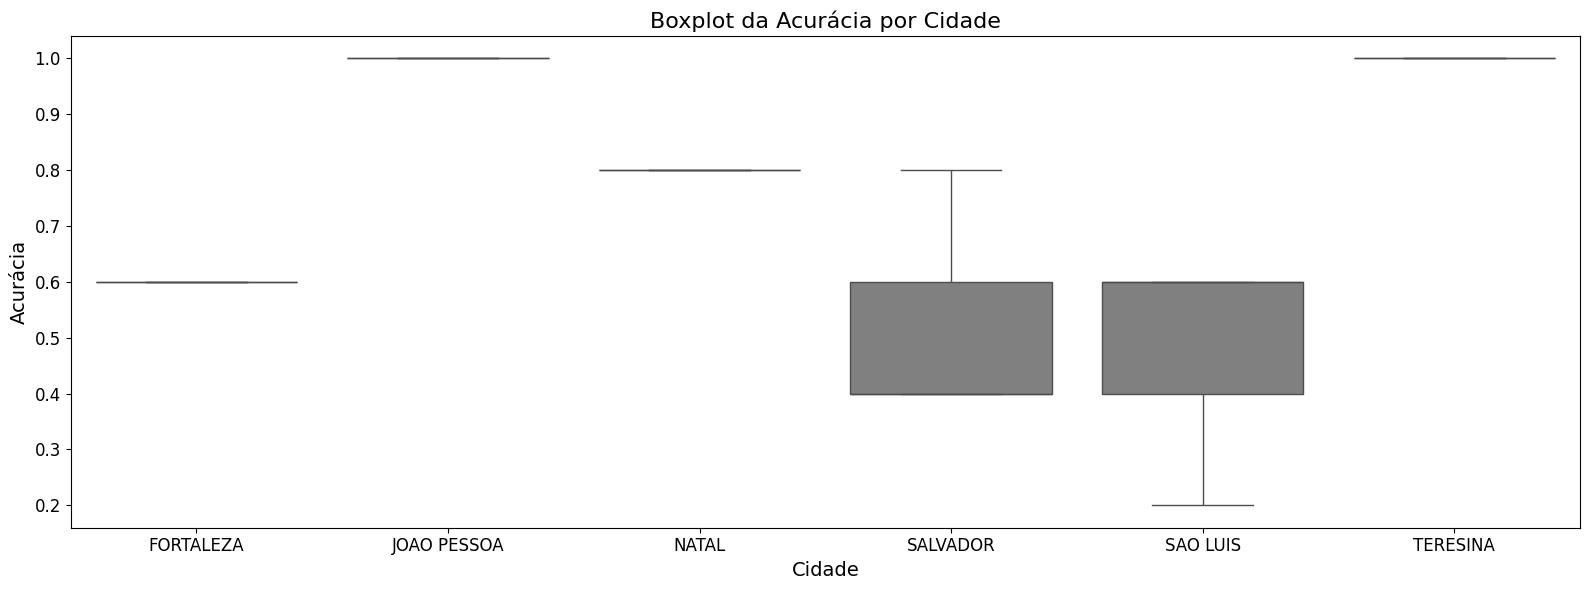

In [67]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_ManParam, x="Cidade", y="Acur√°cia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acur√°cia por Cidade', fontsize=16)
plt.xlabel('Cidade', fontsize=14)
plt.ylabel('Acur√°cia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

Ao analisarmos as acur√°cias por modelo, observamos que a maioria apresenta desempenho semelhante. Os modelos **XGBoost**, **Logistic Regression** e **Random Forest Classifier** tiveram resultados praticamente id√™nticos, com acur√°cias variando entre **0.4** e **1.0**.

Por outro lado, o modelo bayesiano desenvolvido com a biblioteca `pgmpy` apresentou o **pior desempenho**, com acur√°cia chegando a apenas **0.2**, conforme evidenciado no grafo.

O modelo com **melhor desempenho geral** foi o **Support Vector Machine (SVM)**, cuja acur√°cia teve um limite inferior de **0.6**, indicando resultados mais consistentes mesmo nos piores cen√°rios.

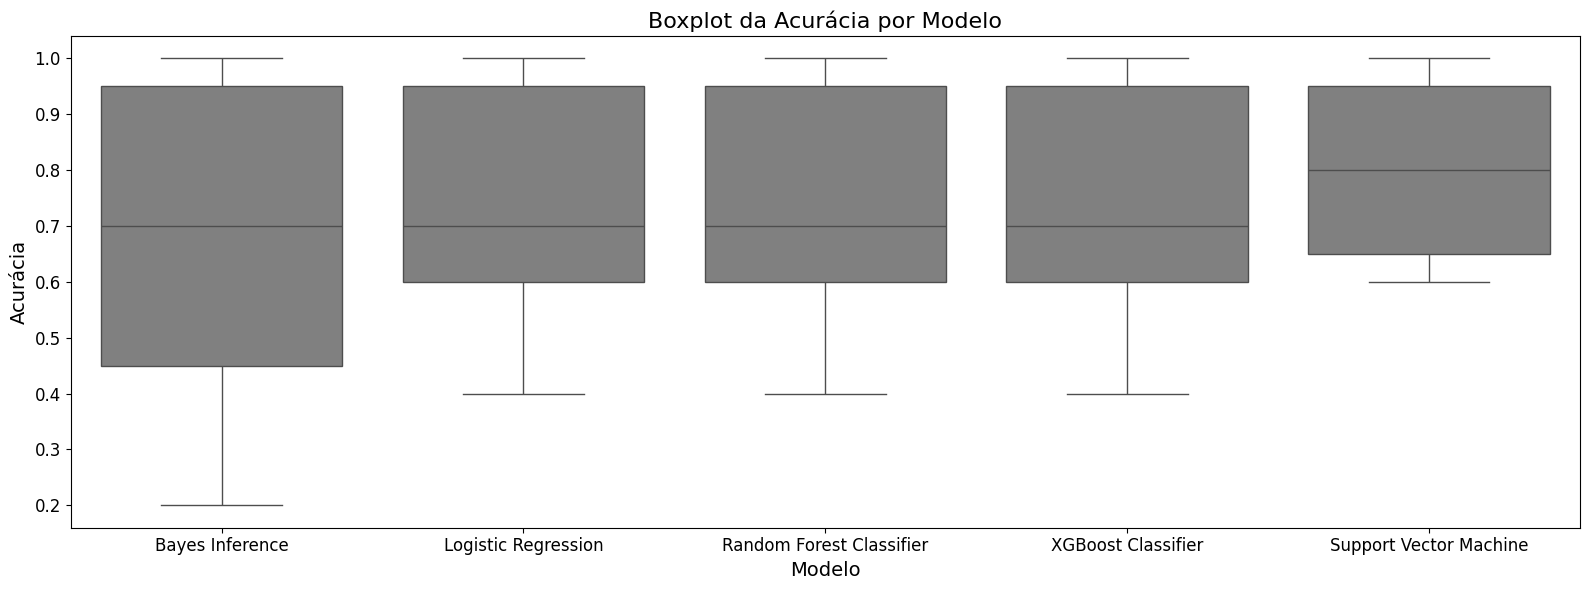

In [68]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_ManParam, x="Modelo", y="Acur√°cia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acur√°cia por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Acur√°cia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### 3.3.1.2. MAE

J√° ao an√°lisarmos a medida MAE para os modelos manualmente definidos temos insight interessantes.

Na avalia√ß√£o dos modelos por meio da m√©trica de erro **MAE (Mean Absolute Error)**, observamos que os classificadores **Random Forest** e **Support Vector Machine (SVM)** apresentaram desempenhos *praticamente id√™nticos*, sugerindo que ambos conseguem capturar padr√µes nos dados de maneira semelhante, com erros m√©dios equivalentes.

Por outro lado, os modelos **XGBoost** e **Regress√£o Log√≠stica** se destacaram por apresentarem **limites inferiores mais baixos nos boxplots**. Isso indica que, em algumas execu√ß√µes ou subconjuntos de dados, esses modelos conseguiram alcan√ßar desempenhos melhores que os demais, evidenciando seu potencial para obter previs√µes mais precisas em certos cen√°rios.

Em contraste, o modelo de infer√™ncia probabil√≠stica baseado em **pgmpy** (biblioteca para redes bayesianas) apresentou tanto o **menor limite inferior quanto o menor limite superior** no boxplot. Essa baixa dispers√£o associada a altos valores de erro sugere que o modelo teve **desempenho consistentemente inferior**, com previs√µes menos precisas de forma geral e pouca varia√ß√£o entre execu√ß√µes. Isso pode indicar limita√ß√µes do modelo em capturar a complexidade dos dados ou uma inadequa√ß√£o ao tipo de problema tratado.

Essas an√°lises refor√ßam a import√¢ncia de comparar n√£o apenas os valores centrais das m√©tricas, mas tamb√©m a **distribui√ß√£o dos erros**, pois oferecem uma vis√£o mais completa sobre a **robustez** e a **consist√™ncia** dos modelos em diferentes condi√ß√µes de teste.


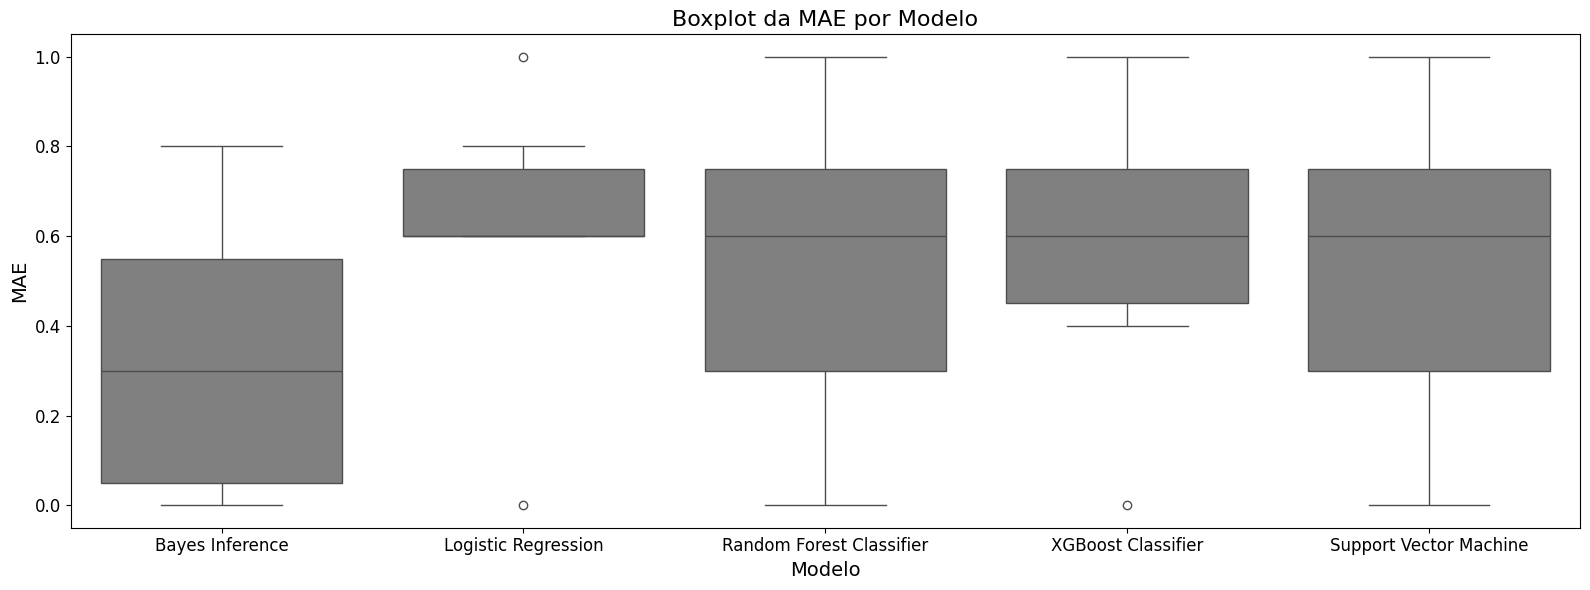

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_ManParam, x="Modelo", y="MAE", color='grey')
# Ajustando os textos
plt.title('Boxplot da MAE por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### Geral

Abaixo podemos ver o dataframe geral que cont√©m as informa√ß√µes sobre a cidade o modelo a acur√°cia e MAE. 

In [69]:
df_combined_ManParam

Cidade                    Modelo  Acur√°cia  MAE
0     FORTALEZA           Bayes Inference       0.6  0.4
1   JOAO PESSOA           Bayes Inference       1.0  0.0
2         NATAL           Bayes Inference       0.8  0.2
3      SALVADOR           Bayes Inference       0.4  0.6
4      SAO LUIS           Bayes Inference       0.2  0.8
5      TERESINA           Bayes Inference       1.0  0.0
6     FORTALEZA       Logistic Regression       0.6  0.8
7     FORTALEZA  Random Forest Classifier       0.6  0.8
8     FORTALEZA        XGBoost Classifier       0.6  0.8
9     FORTALEZA    Support Vector Machine       0.6  0.8
10  JOAO PESSOA       Logistic Regression       1.0  1.0
11  JOAO PESSOA  Random Forest Classifier       1.0  1.0
12  JOAO PESSOA        XGBoost Classifier       1.0  1.0
13  JOAO PESSOA    Support Vector Machine       1.0  1.0
14        NATAL       Logistic Regression       0.8  0.6
15        NATAL  Random Forest Classifier       0.8  0.6
16        NATAL        XGBoost Classifier       0.8  0.6
17        NATAL    Support Vector Machine       0.8  0.6
18     SALVADOR       Logistic Regression       0.4  0.6
19     SALVADOR  Random Forest Classifier       0.4  0.6
20     SALVADOR        XGBoost Classifier       0.6  0.4
21     SALVADOR    Support Vector Machine       0.8  0.6
22     SAO LUIS       Logistic Regression       0.6  0.6
23     SAO LUIS  Random Forest Classifier       0.6  0.2
24     SAO LUIS        XGBoost Classifier       0.4  0.6
25     SAO LUIS    Support Vector Machine       0.6  0.2
26     TERESINA       Logistic Regression       1.0  0.0
27     TERESINA  Random Forest Classifier       1.0  0.0
28     TERESINA        XGBoost Classifier       1.0  0.0
29     TERESINA    Support Vector Machine       1.0  0.0

### 3.3.2. Modelos Otimamente definidos

A seguir veremos as medidas de desempenho para os modelos otimamente definidos.

#### 3.3.2.1 Acur√°cia

Na an√°lise de acur√°cia por cidade, observamos que os **modelos com hiperpar√¢metros otimizados** apresentaram desempenho superior em compara√ß√£o aos modelos definidos manualmente. Essa melhoria √© evidenciada pela **forma mais estreita dos boxplots**, indicando **menor variabilidade nos resultados** e, portanto, maior consist√™ncia nas classifica√ß√µes.

Al√©m disso, os **limites inferiores mais baixos** nos boxplots sugerem que os modelos otimizados conseguiram alcan√ßar **maior acur√°cia m√≠nima**, mesmo nos piores cen√°rios. Isso indica que esses modelos foram mais eficazes na **classifica√ß√£o correta dos dados em diferentes cidades**, apresentando um desempenho mais robusto.

Outro ponto importante √© que os modelos otimizados mostraram **desempenhos bastante semelhantes entre si**, o que refor√ßa a ideia de que a otimiza√ß√£o contribuiu significativamente para a generaliza√ß√£o dos modelos, reduzindo discrep√¢ncias de desempenho entre diferentes algoritmos.

Esses resultados destacam a import√¢ncia da otimiza√ß√£o de hiperpar√¢metros no processo de modelagem, especialmente quando se busca desempenho consistente em diferentes subconjuntos geogr√°ficos dos dados.


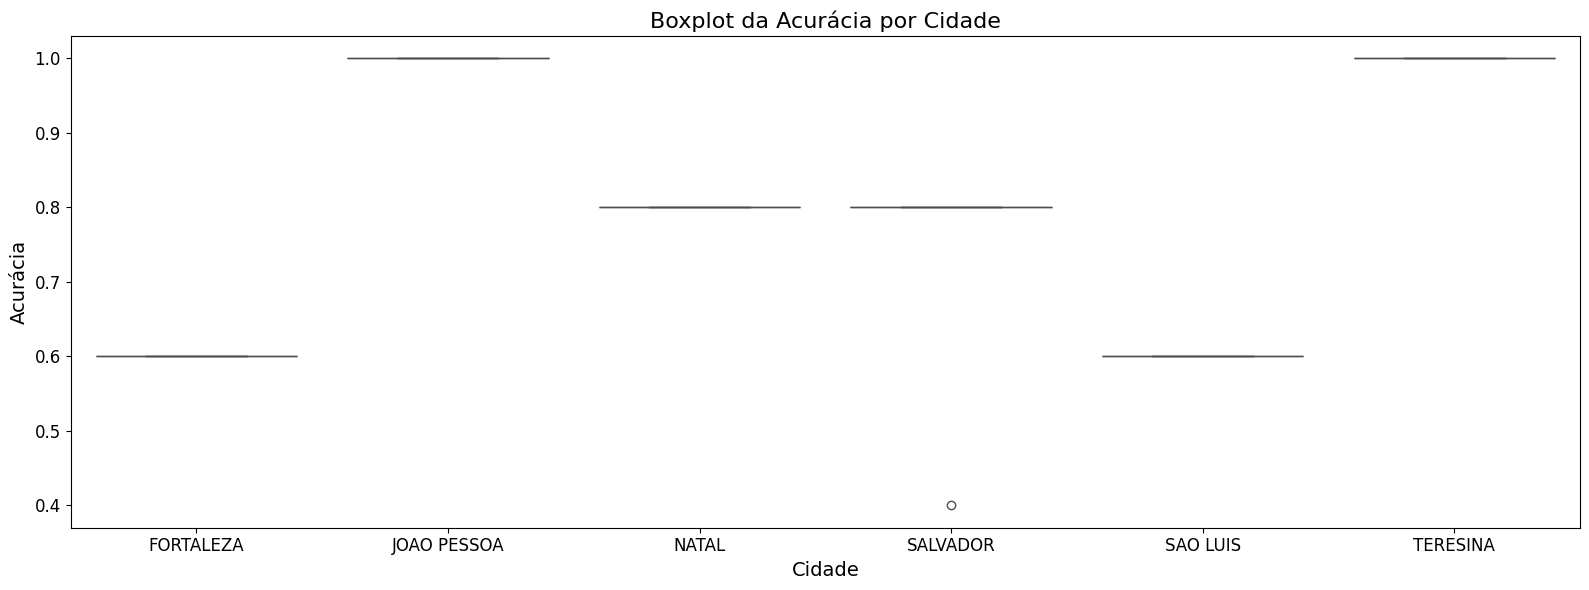

In [70]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_HipParam, x="Cidade", y="Acur√°cia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acur√°cia por Cidade', fontsize=16)
plt.xlabel('Cidade', fontsize=14)
plt.ylabel('Acur√°cia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

O gr√°fico apresentado refor√ßa ainda mais a **semelhan√ßa de desempenho entre os modelos otimizados**. Com exce√ß√£o do **modelo Random Forest**, que apresentou uma acur√°cia ligeiramente inferior, todos os demais modelos obtiveram **resultados praticamente id√™nticos**, evidenciando uma alta consist√™ncia entre eles.

Os modelos otimizados mantiveram **acur√°cia superior a 0.6 em todas as cidades**, um resultado significativamente melhor quando comparado aos modelos definidos manualmente. Isso demonstra o impacto positivo da otimiza√ß√£o de hiperpar√¢metros na qualidade preditiva dos modelos.

Outro ponto de destaque √© o desempenho do **modelo bayesiano**, que anteriormente, entre os modelos manualmente configurados, havia sido o que apresentou pior desempenho. Nesta nova configura√ß√£o otimizada, seu desempenho se iguala ao dos demais modelos, o que ressalta o **potencial da infer√™ncia estat√≠stica bayesiana** quando corretamente ajustada.

Esses resultados refor√ßam a import√¢ncia de m√©todos de otimiza√ß√£o e mostram que at√© mesmo modelos que inicialmente pareceram fracos podem alcan√ßar excelente desempenho quando bem calibrados.


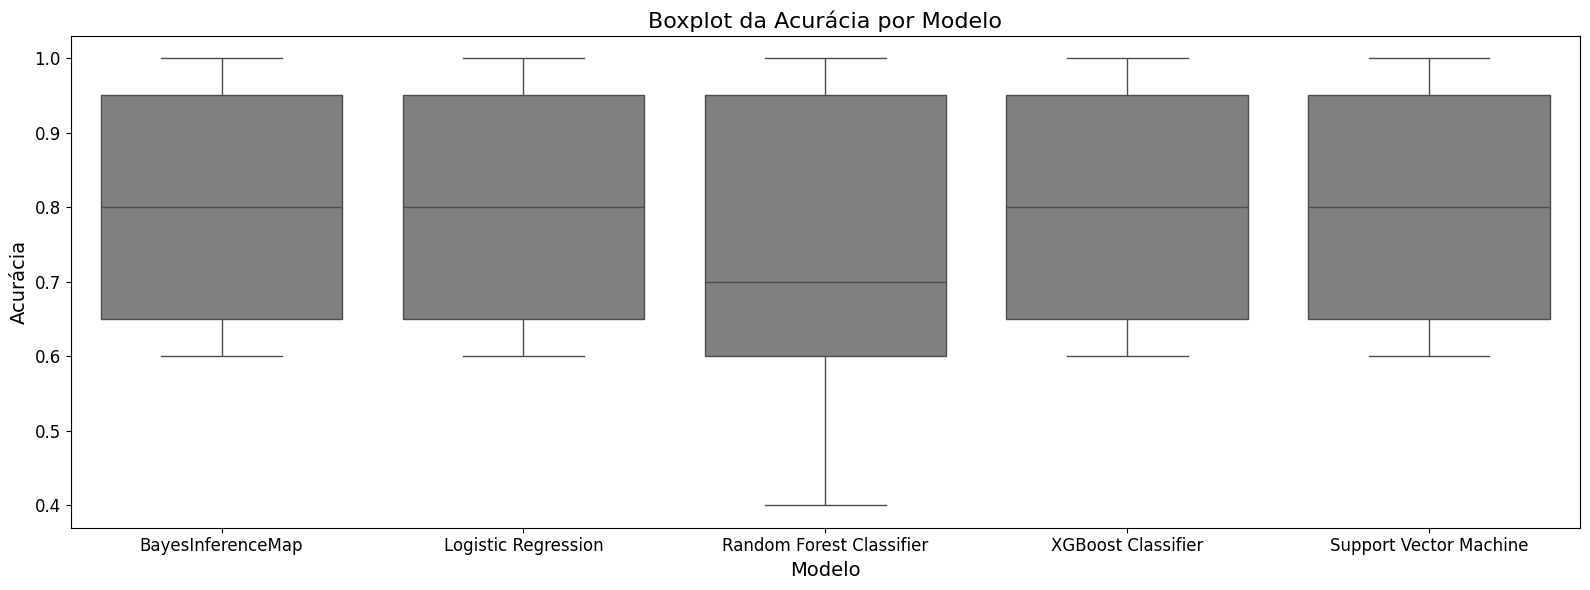

In [71]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_HipParam, x="Modelo", y="Acur√°cia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acur√°cia por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Acur√°cia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### 3.3.2.2 MAE

Ao observar o boxplot da **MAE (Mean Absolute Error)** por modelo, percebemos que os **modelos tradicionais da biblioteca scikit-learn** ‚Äî como Random Forest, SVM, Regress√£o Log√≠stica e XGBoost ‚Äî apresentaram **desempenhos praticamente id√™nticos**, com **limites inferior e superior coincidentes**. Essa uniformidade sugere que, apesar das diferen√ßas em suas arquiteturas, esses modelos foram igualmente eficazes na tarefa, com **pouca varia√ß√£o nos erros absolutos**.

Por outro lado, o **modelo bayesiano**, embora tenha apresentado um **valor m√≠nimo (MAP) inferior aos demais** ‚Äî o que indica que, em certos casos, foi capaz de gerar previs√µes mais precisas ‚Äî, mostrou **menos variabilidade nos dados**. Isso √© evidenciado pelo fato de que seu **limite superior est√° muito pr√≥ximo do terceiro quartil**, e o **limite inferior muito pr√≥ximo do primeiro quartil**, o que resulta em um **boxplot mais ‚Äúcompacto‚Äù**. Al√©m disso, o modelo apresenta **poucos outliers**, o que sugere uma **consist√™ncia maior entre as previs√µes**, mesmo que seu erro m√©dio n√£o tenha sido o menor.

Essa an√°lise indica que o **modelo bayesiano, embora n√£o seja o mais preciso em m√©dia, √© mais est√°vel** e menos suscet√≠vel a grandes erros em diferentes execu√ß√µes. Essa caracter√≠stica pode ser vantajosa em contextos onde a **confiabilidade e a previsibilidade do erro s√£o mais importantes que a acur√°cia m√©dia m√°xima**.

Esses resultados refor√ßam a ideia de que n√£o apenas o valor m√©dio do erro deve ser considerado, mas tamb√©m a **distribui√ß√£o e a variabilidade dos erros**, especialmente ao comparar modelos com caracter√≠sticas estat√≠sticas distintas.


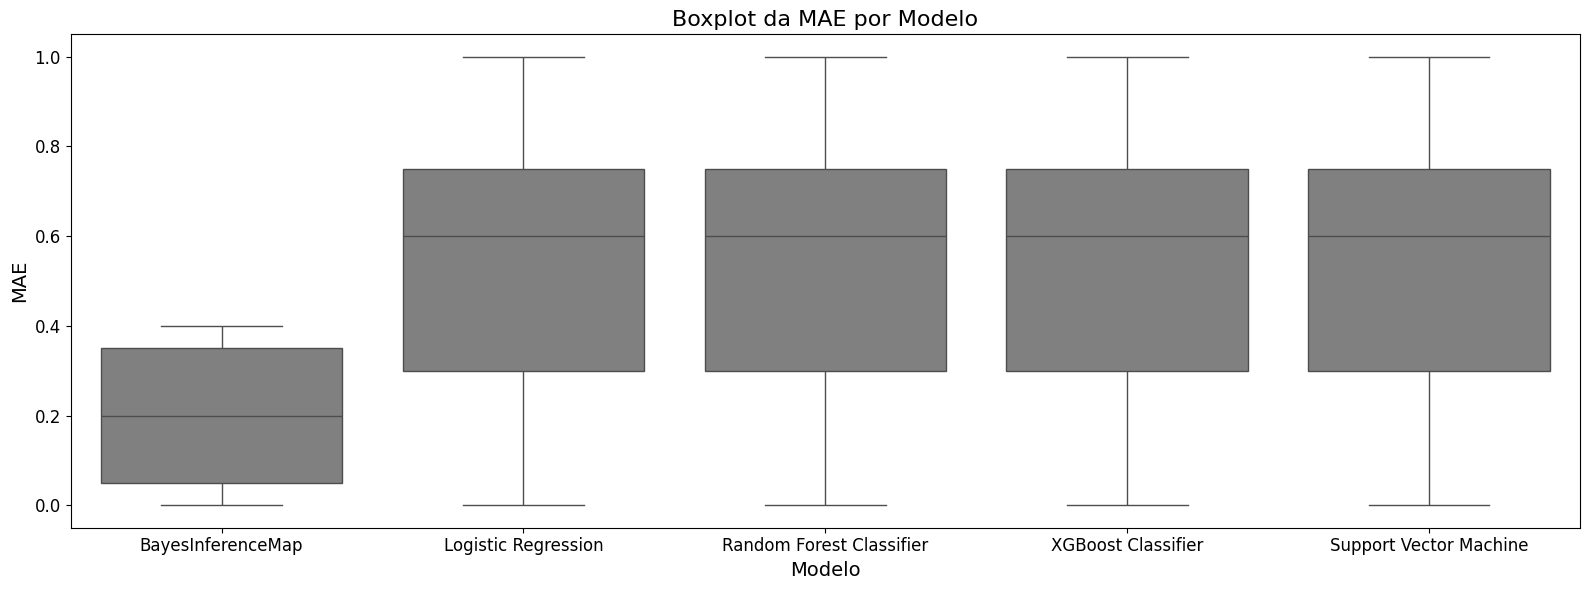

In [73]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_HipParam, x="Modelo", y="MAE", color='grey')
# Ajustando os textos
plt.title('Boxplot da MAE por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### Geral

Abaixo podemos ver o dataframe geral que cont√©m as informa√ß√µes sobre a cidade o modelo a acur√°cia e MAE. 

In [74]:
df_combined_HipParam

Cidade                    Modelo  Acur√°cia  MAE
0     FORTALEZA         BayesInferenceMap       0.6  0.4
1   JOAO PESSOA         BayesInferenceMap       1.0  0.0
2         NATAL         BayesInferenceMap       0.8  0.2
3      SALVADOR         BayesInferenceMap       0.8  0.2
4      SAO LUIS         BayesInferenceMap       0.6  0.4
5      TERESINA         BayesInferenceMap       1.0  0.0
6     FORTALEZA       Logistic Regression       0.6  0.8
7     FORTALEZA  Random Forest Classifier       0.6  0.8
8     FORTALEZA        XGBoost Classifier       0.6  0.8
9     FORTALEZA    Support Vector Machine       0.6  0.8
10  JOAO PESSOA       Logistic Regression       1.0  1.0
11  JOAO PESSOA  Random Forest Classifier       1.0  1.0
12  JOAO PESSOA        XGBoost Classifier       1.0  1.0
13  JOAO PESSOA    Support Vector Machine       1.0  1.0
14        NATAL       Logistic Regression       0.8  0.6
15        NATAL  Random Forest Classifier       0.8  0.6
16        NATAL        XGBoost Classifier       0.8  0.6
17        NATAL    Support Vector Machine       0.8  0.6
18     SALVADOR       Logistic Regression       0.8  0.6
19     SALVADOR  Random Forest Classifier       0.4  0.6
20     SALVADOR        XGBoost Classifier       0.8  0.6
21     SALVADOR    Support Vector Machine       0.8  0.6
22     SAO LUIS       Logistic Regression       0.6  0.2
23     SAO LUIS  Random Forest Classifier       0.6  0.2
24     SAO LUIS        XGBoost Classifier       0.6  0.2
25     SAO LUIS    Support Vector Machine       0.6  0.2
26     TERESINA       Logistic Regression       1.0  0.0
27     TERESINA  Random Forest Classifier       1.0  0.0
28     TERESINA        XGBoost Classifier       1.0  0.0
29     TERESINA    Support Vector Machine       1.0  0.0